In [1]:
import numpy as np
from pprint import pprint
from devices import Chadoq2
from sequences import Sequence
from pulses import Pulse

#### 1. Defining the positions of the atoms and naming the qubit on each position

In [2]:
L = 4
square = np.array([[i, j] for i in range(L) for j in range(L)], dtype=float)
square -= np.mean(square, axis=0)
square *= 5

qubits = dict(enumerate(square))
qubits

{0: array([-7.5, -7.5]),
 1: array([-7.5, -2.5]),
 2: array([-7.5,  2.5]),
 3: array([-7.5,  7.5]),
 4: array([-2.5, -7.5]),
 5: array([-2.5, -2.5]),
 6: array([-2.5,  2.5]),
 7: array([-2.5,  7.5]),
 8: array([ 2.5, -7.5]),
 9: array([ 2.5, -2.5]),
 10: array([2.5, 2.5]),
 11: array([2.5, 7.5]),
 12: array([ 7.5, -7.5]),
 13: array([ 7.5, -2.5]),
 14: array([7.5, 2.5]),
 15: array([7.5, 7.5])}

#### 2. Initializing a device and the Sequence

In [3]:
device = Chadoq2(qubits)
seq = Sequence(device)

#### 3. Declaring the channels that will be used

Inspecting what channels are available on this device:

In [4]:
seq.available_channels

{'rydberg_global': Rydberg(global, Max Absolute Detuning: 50 MHz, Max Amplitude: 2.5 MHz),
 'rydberg_local': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns),
 'rydberg_local2': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns),
 'raman_local': Raman(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns)}

We're going to choose the `'rydberg_local'` and `'raman_local'` channels. Note how a declared channel is no longer reported as available.

In [5]:
seq.declare_channel('ch0', 'raman_local')
print("Available channels after declaring 'ch0':")
pprint(seq.available_channels)

seq.declare_channel('ch1', 'rydberg_local', initial_target=4)
print("\nAvailable channels after declaring 'ch1':")
pprint(seq.available_channels)

Available channels after declaring 'ch0':
{'rydberg_global': Rydberg(global, Max Absolute Detuning: 50 MHz, Max Amplitude: 2.5 MHz),
 'rydberg_local': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns),
 'rydberg_local2': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns)}

Available channels after declaring 'ch1':
{'rydberg_global': Rydberg(global, Max Absolute Detuning: 50 MHz, Max Amplitude: 2.5 MHz),
 'rydberg_local2': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns)}


At any time, we can also consult which channels were declared, their specifications and the name they were given by calling:

In [6]:
seq.declared_channels

{'ch0': Raman(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns),
 'ch1': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns)}

#### 4. Composing the Sequence

Every channel needs to start with a target. For `'global'` channels this is predefined to be all qubits in the device, but for `'local'` channels this has to be defined. This initial target can be set through at channel declaration (see how `'ch1'` was set to target qubit `4`), or it can be done through the standard `target` instruction.

In [7]:
seq.target(1, 'ch0')

Now both channels have an initial target, so we can start building the sequence. Let's start by creating a simple pulse with a constant amplitude of 2 MHz and a constant detuning of -10 MHz that lasts 200 ns.

In [8]:
simple_pulse = Pulse.ConstantPulse(200, 2, -10, 0)

Let's add this pulse to `'ch0'`:

In [9]:
seq.add(simple_pulse, 'ch0')

Now, say we want to idle `'ch1'` for 100 ns while `'ch0'` is doing its pulse. We do that by calling: 

In [10]:
seq.delay(100, 'ch1')

Next, we want to create a more complex pulse to add to `'ch1'`, where the amplitude and the detuning are not constant. To do that, we use `Waveform`s:

In [11]:
from waveforms import RampWaveform, GaussianWaveform

duration = 1000
amp_wf = GaussianWaveform(duration, 1, 150)   # Duration: 1000 ns, Max Amp: 1 MHz, Stdev: 150 ns
detuning_wf = RampWaveform(duration, -20, 20)  # Duration: 1000ns, linear sweep from -20 to 20 MHz

We can visualize a waveform by calling:

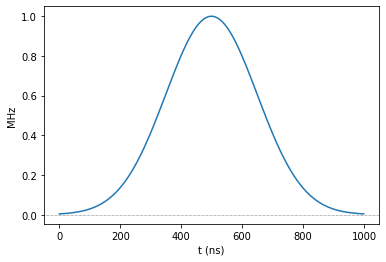

In [12]:
amp_wf.draw()

Also, it is often convenient to find the integral of a waveform, which can be obtain by calling:

In [13]:
amp_wf.integral   # dimensionless

0.375671599924872

We then create the pulse with the waveforms instead of fixed values and we can also visualize it:

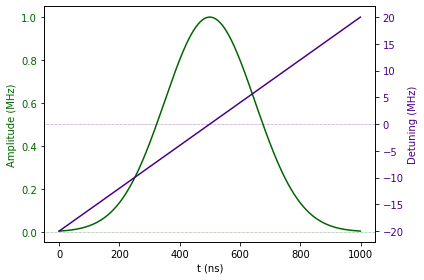

In [14]:
complex_pulse = Pulse(amp_wf, detuning_wf, phase=0)
complex_pulse.draw()

When we're satisfied, we can then add it to a channel:

In [15]:
seq.add(complex_pulse, 'ch1')

Let's check the schedule to see how this is looking:

In [16]:
print(seq)

Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 MHz, Detuning=-10 MHz, Phase=0) | Targets: 1

Channel: ch1
t: 0 | Initial targets: 4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Gaussian(0->1 MHz, sigma=150 ns), Detuning=Ramp(-20->20 MHz), Phase=0) | Targets: 4




We can also draw the sequence, for a more visual representation:

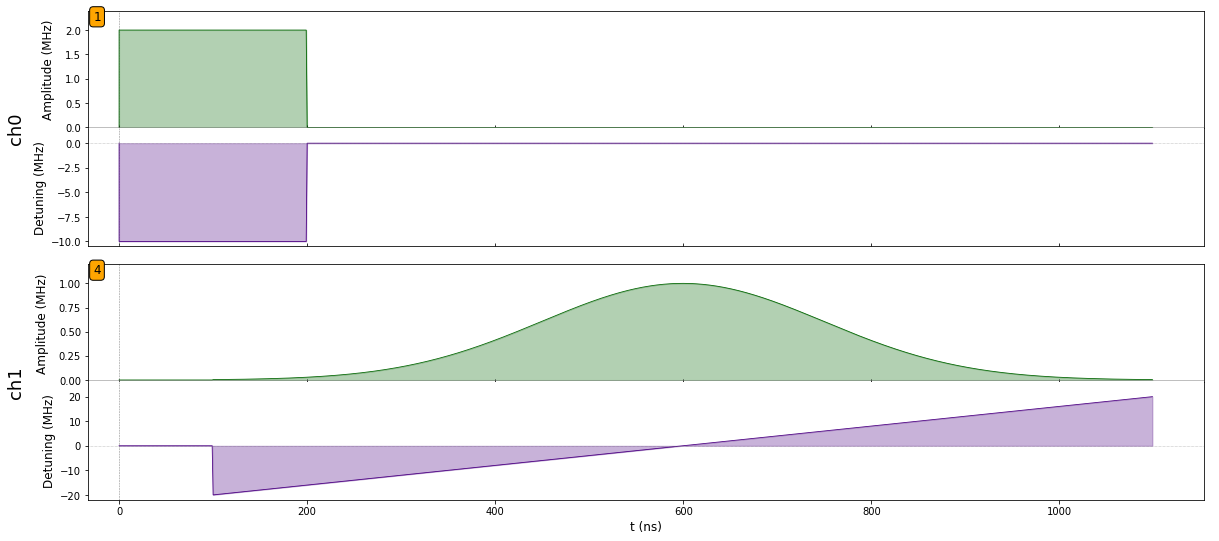

In [17]:
seq.draw()

Now, let's see how the Sequence builder handles conflicts (i.e. two channels acting on the same qubit at once). We're going to add a `complex_pulse`to `'ch0'`, but now we want to target it to qubit `4`, which is the same target of `'ch1'`.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 MHz, Detuning=-10 MHz, Phase=0) | Targets: 1
t: 200->300 | Target: 4 | Phase Reference: 0.0
t: 300->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Gaussian(0->1 MHz, sigma=150 ns), Detuning=Ramp(-20->20 MHz), Phase=0) | Targets: 4

Channel: ch1
t: 0 | Initial targets: 4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Gaussian(0->1 MHz, sigma=150 ns), Detuning=Ramp(-20->20 MHz), Phase=0) | Targets: 4




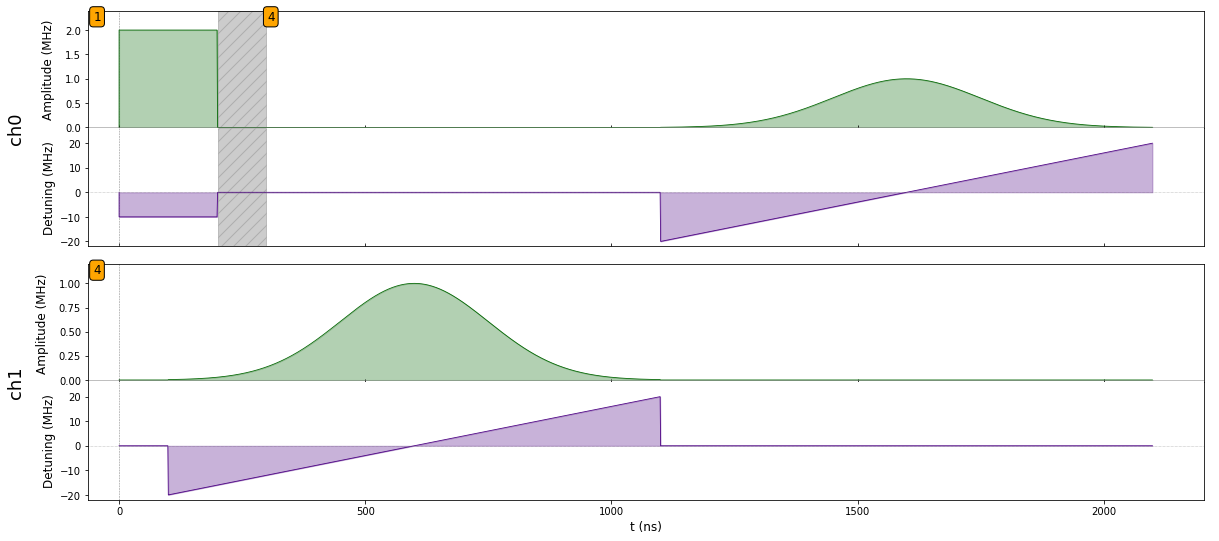

In [18]:
seq.target(4, 'ch0')
seq.add(complex_pulse, 'ch0')

print("Current Schedule:")
print(seq)
seq.draw()

By looking at the current schedule, we can see that `'ch0'` was delayed from `ti=300` to `tf=1100`, and only then was the `complex_pulse` added. The reason for this is simple: it had to wait for the pulse on `ch1`, also targeted to qubit `4`, to finish before it could apply its own. It behaved this way because, in `Sequence.add` there is a default argument `protocol='min-delay`.

Another protocol for pulse addition is `wait-for-all`, which makes the new pulse wait even if there is no conflict. Let's remove the conflict and add two `simple_pulse`s to `ch1` with the different protocols to see how the compare.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 MHz, Detuning=-10 MHz, Phase=0) | Targets: 1
t: 200->300 | Target: 4 | Phase Reference: 0.0
t: 300->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Gaussian(0->1 MHz, sigma=150 ns), Detuning=Ramp(-20->20 MHz), Phase=0) | Targets: 4

Channel: ch1
t: 0 | Initial targets: 4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Gaussian(0->1 MHz, sigma=150 ns), Detuning=Ramp(-20->20 MHz), Phase=0) | Targets: 4
t: 1100->1200 | Target: 0 | Phase Reference: 0.0
t: 1200->1400 | Pulse(Amp=2 MHz, Detuning=-10 MHz, Phase=0) | Targets: 0
t: 1400->2100 | Delay 
t: 2100->2300 | Pulse(Amp=2 MHz, Detuning=-10 MHz, Phase=0) | Targets: 0




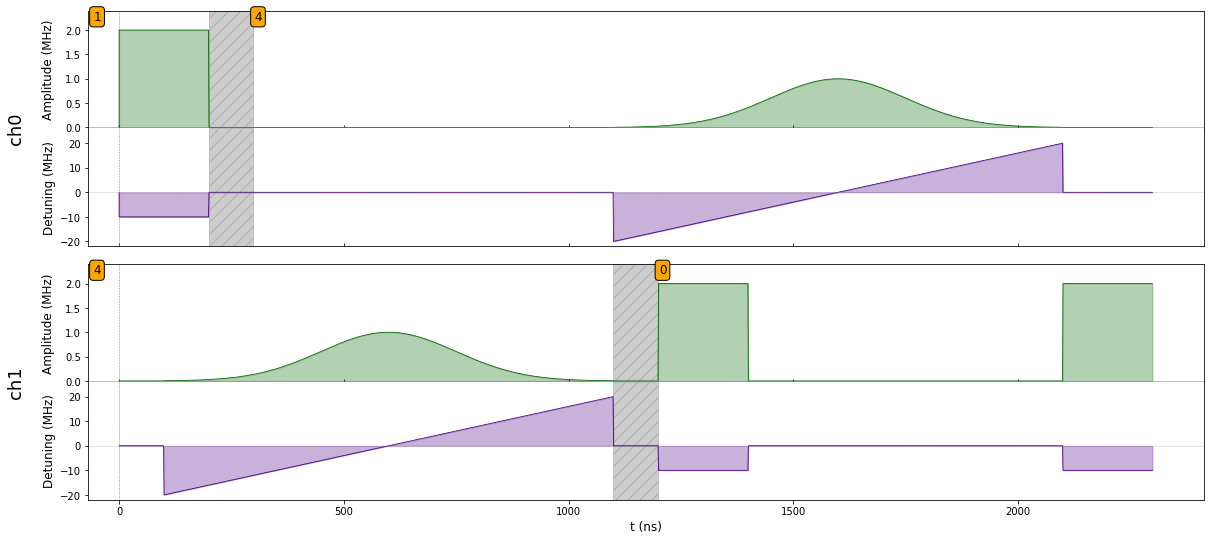

In [19]:
seq.target(0, 'ch1')
seq.add(simple_pulse, 'ch1', protocol='min-delay')
seq.add(simple_pulse, 'ch1', protocol='wait-for-all')

print("Current Schedule:")
print(seq)
seq.draw()

Because we removed the conflict by changing the target of `ch1` to qubit `0`, we see that the first pulse was added without delay from `ti=1200` to `tf=1400` (i.e. while `complex_pulse` is still running in `ch0`). However, once we changed to `protocol='wait-for-all'`, there is now a delay (from `ti=1400` to `tf=2100`) that idles `ch1` until `ch0`is finished with its pulse, even though there was no conflict.

The third protocol is called `'no-delay'` which, as the name implies, never delays the channel where the pulse is being added, even if that means introducing a conflict.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: 1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 MHz, Detuning=-10 MHz, Phase=0) | Targets: 1
t: 200->300 | Target: 4 | Phase Reference: 0.0
t: 300->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Gaussian(0->1 MHz, sigma=150 ns), Detuning=Ramp(-20->20 MHz), Phase=0) | Targets: 4
t: 2100->2200 | Target: 0 | Phase Reference: 0.0
t: 2200->3200 | Pulse(Amp=Gaussian(0->1 MHz, sigma=150 ns), Detuning=Ramp(-20->20 MHz), Phase=0) | Targets: 0

Channel: ch1
t: 0 | Initial targets: 4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Gaussian(0->1 MHz, sigma=150 ns), Detuning=Ramp(-20->20 MHz), Phase=0) | Targets: 4
t: 1100->1200 | Target: 0 | Phase Reference: 0.0
t: 1200->1400 | Pulse(Amp=2 MHz, Detuning=-10 MHz, Phase=0) | Targets: 0
t: 1400->2100 | Delay 
t: 2100->2300 | Pulse(Amp=2 MHz, Detuning=-10 MHz, Phase=0) | Targets: 0




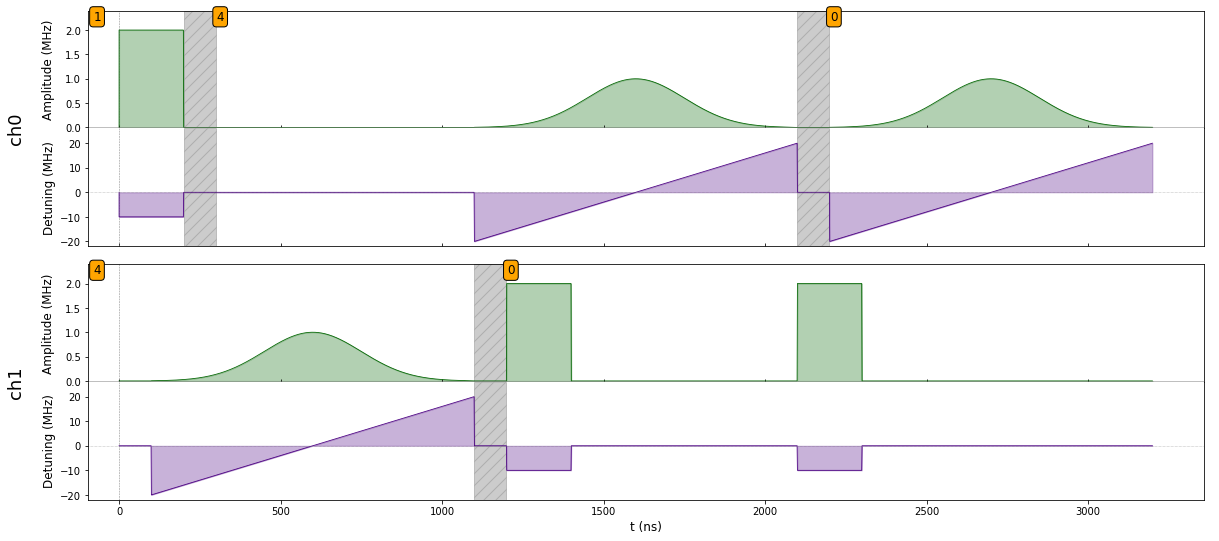

In [20]:
seq.target(0, 'ch0')
seq.add(complex_pulse, 'ch0', protocol='no-delay')

print("Current Schedule:")
print(seq)
seq.draw()

With this protocol, it is possible (though not advised), to create an overlap where multiple channels can be acting on the same qubit at the same time. Here, we can see that both act on qubit `0` from `ti=2200` to `tf=2300`.

#### 5. Measurement

To finish a sequence, we measure it. A measurement signals the end of a sequence, so after it no more changes are possible. We can measure a sequence by calling:

In [21]:
seq.measure(basis='ground-rydberg')

When measuring, one has to select the desired measurement basis. The availabe options depend on the device and can be consulted by calling:

In [22]:
device.supported_bases

{'digital', 'ground-rydberg'}

And so, we've obtained the final sequence!

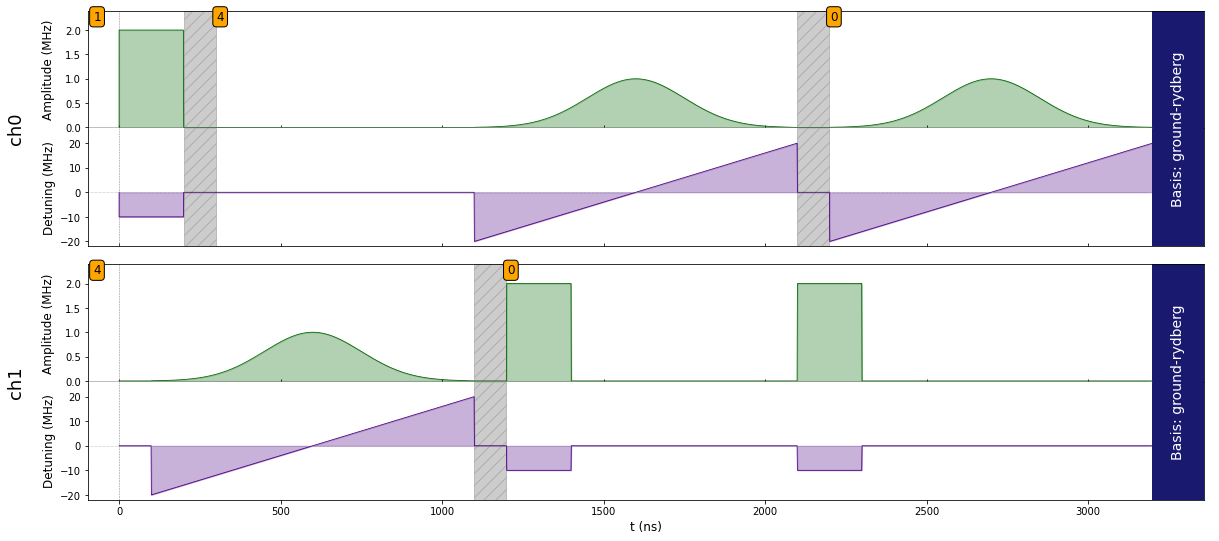

In [23]:
seq.draw()